In [1]:
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy
import random
import gym

%matplotlib inline

In [2]:
tf.reset_default_graph()
sess = tf.Session()

In [3]:
def copy_net(name1, name2):
    variables = tf.trainable_variables()
    for var1 in variables:
        if name2+"/" in var1.name:
            trained_var = [var2 for var2 in tf.trainable_variables() if var2.op.name in str.replace(var1.name, name2+"/", name1+"/")][0]
            value = sess.run(trained_var)
            sess.run(tf.assign(var1, value))

In [4]:
# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))

In [5]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)

        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//nproc)):
            env.step(env.action_space.sample())
        return env
    return _f

In [6]:
env_name = "MountainCar-v0"
discount = 0.97
state_queue_size = 1
learning_rate = 0.01

iterations = 10000
batch_size = 64
update_net_period = 10
history_size = 64*4
stochastic_action_likelihood = 0.9
stochastic_action_likelihood_d = (stochastic_action_likelihood - 0.1) / iterations #TODO: adaptive stoch_action_l_d; endpoint: 0.1

nproc = 30
envs = DummyVecEnv([make_env(env_name, seed) for seed in range(nproc)]) #Dummy
        
# This code gets action and observation space sizes for 1D tasks
action_space_size = envs.action_space.n if isinstance(envs.action_space, gym.spaces.discrete.Discrete) else envs.action_space.shape[0]
observation_space_size = envs.observation_space.n if isinstance(envs.observation_space, gym.spaces.discrete.Discrete) else envs.observation_space.shape[0]

plots_data = {
    "reward": [],
    "loss": [],
    "gradients_max_abs": [],
    "gradients_equal_zero": [],
    "max_action": [],
    "max_qvals": [],
    "min_qvals": [],
}

In [7]:
class QualityNet:
    def __init__(self, net_name):
        with tf.variable_scope(net_name + "/"):
            layers_config = (action_space_size + state_queue_size*observation_space_size, 32) # 32 - hidden layer size

            self.input_state = tf.placeholder(tf.float32, shape=[None, state_queue_size, observation_space_size], name="input_state")
            self.flattened_state = tf.reshape(self.input_state, [-1, observation_space_size * state_queue_size])
            self.input_action = tf.placeholder(tf.int32, shape=[None], name="input_action")
            input_action_one_hot = tf.one_hot(self.input_action, depth=action_space_size)
            
            self.input_data = tf.concat([self.flattened_state, input_action_one_hot], 1)
            
            self.input_layer = tf.layers.dense(self.input_data, units=layers_config[0], activation='relu')
            self.hidden_layer = tf.layers.dense(self.input_layer, units=layers_config[1], activation='relu')
            self.output_layer = tf.layers.dense(self.hidden_layer, units=1)
            
            self.exp_value = tf.placeholder(tf.float32, name="exp_value") #  shape=[None] WTF???
            self.loss = tf.losses.mean_squared_error(self.exp_value, self.output_layer)
            
            self.gradients = tf.gradients(self.loss, [t_var for t_var in tf.trainable_variables() if "train_net/" in t_var.name]) # For Debug!
            
            optimizer = tf.train.RMSPropOptimizer(learning_rate)
            self.train_op = optimizer.minimize(self.loss)

prediction_net = QualityNet("prediction_net")
train_net = QualityNet("train_net")     

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

W0716 20:16:53.034515 14596 deprecation.py:323] From <ipython-input-7-bc485f033a11>:13: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0716 20:16:53.041469 14596 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 20:16:53.332725 14596 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\losses\losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0716 20:16:53.47

In [8]:
def prepare_input(states_q):
    return np.repeat(np.array(states_q), repeats=action_space_size, axis=0), np.tile(range(action_space_size), len(states_q))

In [9]:
def update_state(state_queue, val):
    state_queue.pop()
    state_queue.insert(0, val)

def batch_generator(batch_size, history_size):
    """
        history[0] = queue of four last states
        history[1] = action
        history[2] = reward
        history[3] = states queue with new state
        history[4] = discounted reward
    """
    states_q = [[np.random.sample(observation_space_size) for _ in range(state_queue_size)] for _ in range(nproc)] #observation_space_size refactor
    trajectories = [np.empty((0, 4)) for _ in range(nproc)]

    history = np.empty((0, 5))
    observations = envs.reset()
    for pid in range(nproc):
        update_state(states_q[pid], observations[pid])

    while True:
        history = history[batch_size:]
        while len(history) < history_size:
            if random.random() < stochastic_action_likelihood:
                actions = np.stack([envs.action_space.sample() for _ in range(nproc)]) # test
            else:
                ############ action prediction ############
                input_states, input_actions = prepare_input(states_q)
                qvalues = sess.run((prediction_net.output_layer), feed_dict={
                        prediction_net.input_state: input_states,
                        prediction_net.input_action: input_actions,
                    })
                qvalues = qvalues.reshape(len(qvalues) // action_space_size, action_space_size)
                plots_data["max_qvals"].append(qvalues.max(axis=1)[0])
                plots_data["min_qvals"].append(qvalues.min(axis=1)[0])
                actions = np.argmax(qvalues, axis=1)
                ###########################################
            observations, rewards, dones, _ = envs.step(actions)
            rewards /= 200

            for pid in range(nproc):
                new_state = copy.deepcopy(states_q[pid])
                update_state(new_state, observations[pid])

                trajectories[pid] = np.vstack((trajectories[pid], [states_q[pid], actions[pid], rewards[pid], new_state]))

                if dones[pid]:
                    ################ qvalues prediction ################
                    input_states, input_actions = prepare_input(trajectories[pid][:-1][:, 3])
                    qvalues = sess.run((prediction_net.output_layer), feed_dict={
                            prediction_net.input_state: np.array(input_states.tolist()),
                            prediction_net.input_action: input_actions,
                        })
                    qvalues = qvalues.reshape(len(qvalues) // action_space_size, action_space_size).max(axis=1)
                    qvalues *= discount
                    qvalues = qvalues + trajectories[pid][:-1][:, 2]
                    qvalues = np.append(qvalues, rewards[pid])
                    ####################################################

                    new_history = np.hstack((trajectories[pid], np.expand_dims(qvalues, axis=-1)))   
                    plots_data["reward"].append((trajectories[pid][:-1][:, 2].sum() + rewards[pid]) * 200)
                    trajectories[pid] = np.empty((0, 4))
                    history = np.vstack((history, new_history))

        np.random.shuffle(history)
        yield history[:batch_size]

In [10]:
batch_gen = batch_generator(batch_size, history_size)

for i in range(10):
    next(batch_gen)

for i in tqdm_notebook(range(iterations)):
    batch = next(batch_gen)

    input_state = [batch[:, 0][i] for i in range(len(batch))]
    input_action = batch[:, 1]

    _, loss, gradients = sess.run((train_net.train_op, train_net.loss, train_net.gradients), 
                       feed_dict = {
                            train_net.input_state: input_state,
                            train_net.input_action: input_action,
                            train_net.exp_value: batch[:, 4],
                        })

    #****************** DEBUG ******************* 
    plots_data["loss"].append(loss)
    plots_data["gradients_max_abs"].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients]))
    plots_data["gradients_equal_zero"].append(len(gradients[gradients == 0]))
    #*********************************************

    if i % update_net_period == 0:
        copy_net("train_net", "prediction_net")

    stochastic_action_likelihood -= stochastic_action_likelihood_d

KeyboardInterrupt: 

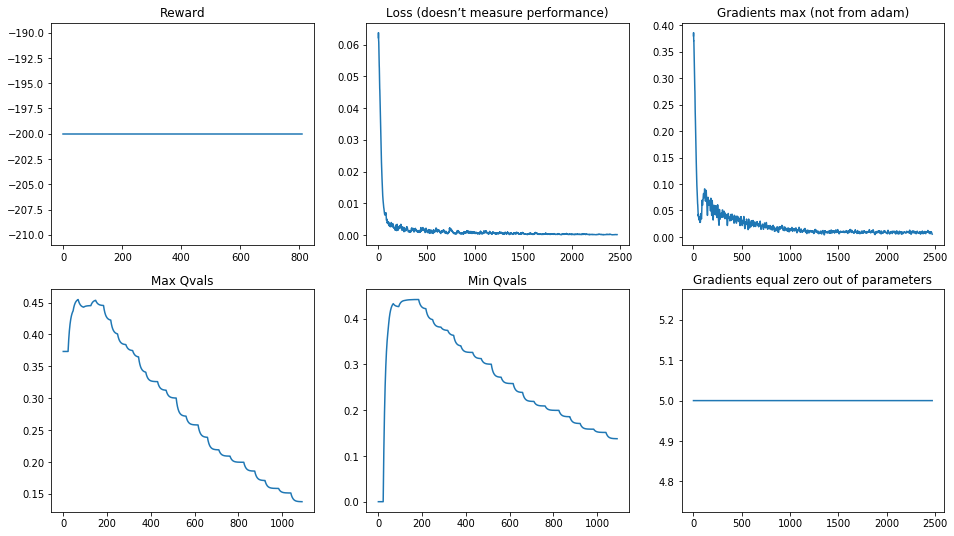

In [11]:
#************ Plotting debug info ****************
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(plots_data["reward"], "Reward", axs[0, 0])
plot(plots_data["loss"], "Loss (doesn’t measure performance)", axs[0, 1])
plot(plots_data["max_qvals"], "Max Qvals", axs[1, 0])
plot(plots_data["min_qvals"], "Min Qvals", axs[1, 1])
plot(plots_data["gradients_max_abs"], "Gradients max (not from adam)", axs[0, 2])
plot(plots_data["gradients_equal_zero"], f"Gradients equal zero out of parameters", axs[1, 2])
#*************************************************

In [12]:
x = np.linspace(-1, 1, num=21)
y = np.linspace(-1, 1, num=21)
input_state = np.expand_dims(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]), axis=1)
input_action = np.tile([0,1,2], len(input_state))
input_state = np.repeat(input_state, 3, axis=0)

output = sess.run((prediction_net.output_layer), feed_dict={
    prediction_net.input_state: input_state,
    prediction_net.input_action: input_action,
})

print("MAX Q:", output.max())        
print("MIN Q:", output.min())

MAX Q: 0.41681033
MIN Q: 0.108504914
